<a href="https://colab.research.google.com/github/bjelikj/DT2119/blob/Lab3_Andres/Labs/Lab3/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

reload_files = True
feature = 'lmfcc'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
"""
Necessary files:
- lab1_proto.py
- lab1_tools.py
- lab2_proto.py
- lab2_tools.py
- lab3_proto.py
- lab3_tools.py
- prondict.py
- standardization.py

If not uploaded to Google Drive:
- lab2_models_all.npz
- lab3_example.npz
"""

if reload_files:
  # %pwd
  !pwd
  if IN_COLAB:
      !rm -r ./*.py

  from google.colab import files
  files.upload()

/content


Saving lab1_proto.py to lab1_proto.py
Saving lab1_tools.py to lab1_tools.py
Saving lab2_proto.py to lab2_proto.py
Saving lab2_tools.py to lab2_tools.py
Saving lab3_proto.py to lab3_proto.py
Saving lab3_tools.py to lab3_tools.py
Saving norm_dynmspec.py to norm_dynmspec.py
Saving prondict.py to prondict.py
Saving standardization.py to standardization.py


In [3]:
from lab1_proto import *
from lab2_proto import *
from lab3_proto import *
from lab1_tools import *
from lab2_tools import *
from lab3_tools import *
from prondict import prondict
from standardization import *

import numpy as np
import os

Using TensorFlow backend.


## Check examples


In [0]:
example = np.load('/content/drive/My Drive/Lab3/lab3_example.npz', allow_pickle=True)['example'].item()

# 4.1 Target Class Definition

In [5]:
phoneHMMs = np.load('/content/drive/My Drive/Lab3/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
print(stateList)

['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']


# 4.2 Forced Alignment

In [6]:
filename = '/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)
print("LMFCC Shape: ", lmfcc.shape)

wordTrans = list(path2info(filename)[2])
print("Sequence of digits: ", wordTrans)

print("Pronunciation dictionary: ", prondict)

phoneTrans = words2phones(wordTrans, prondict)
print("Phone level transcription: ", phoneTrans)
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans
              for stateid in range(nstates[phone])]

LMFCC Shape:  (178, 13)
Sequence of digits:  ['z', '4', '3']
Pronunciation dictionary:  {'o': ['ow'], 'z': ['z', 'iy', 'r', 'ow'], '1': ['w', 'ah', 'n'], '2': ['t', 'uw'], '3': ['th', 'r', 'iy'], '4': ['f', 'ao', 'r'], '5': ['f', 'ay', 'v'], '6': ['s', 'ih', 'k', 's'], '7': ['s', 'eh', 'v', 'ah', 'n'], '8': ['ey', 't'], '9': ['n', 'ay', 'n']}
Phone level transcription:  ['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']


In [7]:
# Compare with examples
for i in example['utteranceHMM'].keys():
    print(compare(utteranceHMM[i], example['utteranceHMM'][i]))

obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))
viterbiStateTrans = [stateTrans[idx] for idx in viterbi_path.astype(np.int64)] # Forced Alignment

print('Comparing obsloglik...', compare(obsloglik, example['obsloglik']))
print('Comparing viterbiPath...', compare(viterbi_path, example['viterbiPath']))
print('Comparing viterbiStateTrans...', np.all(viterbiStateTrans == example['viterbiStateTrans']))

frames = frames2trans(viterbiStateTrans, outfilename= ''.join(path2info(filename)[2:]) + '.lab')

True
True
True
True
Comparing obsloglik... True
Comparing viterbiPath... True
Comparing viterbiStateTrans... True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


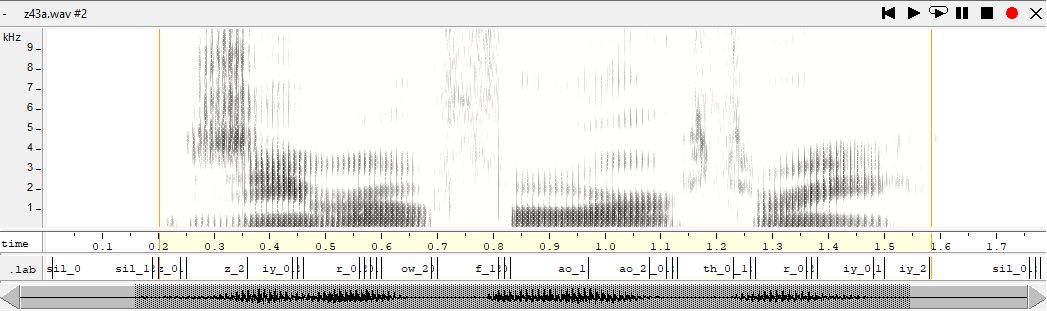

In [8]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Lab3/z43a_wavesurfer.png')

# 4.3 Feature Extraction

In [0]:
def extract_features_and_targets(filename):
    """ extract_features_and_targets: extracts lmfcc, mspecc and 
        targets from a *.wav sound file

    Args:
        filename: location of .wav file

    Returns:
        lmfcc: liftered mfcc features
        mspec: filterbank features
        targets: indices of the target state for each feature
    """
    samples, samplingrate = loadAudio(filename)
    wordTrans = list(path2info(filename)[2])
    phoneTrans = words2phones(wordTrans, prondict)
    stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans 
                  for stateid in range(nstates[phone])]
    utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

    stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans
              for stateid in range(nstates[phone])]

    lmfcc = mfcc(samples)
    mspec_ = mspec(samples)

    obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
    viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
    targets = [stateTrans[idx] for idx in viterbi_path.astype(np.int64)] 

    return lmfcc, mspec_, targets

Extract and save lmfcc and mspec features, and their associated targets

In [10]:
"""
from tqdm import tqdm
traindata = []
for root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train'), desc='dirs'):
  for file in files:
    if file.endswith('.wav'):
      filename = os.path.join(root, file)
      samples, samplingrate = loadAudio(filename)
      lmfcc, mspec_, targets =  extract_features_and_targets(filename)
      traindata.append({'filename': filename, 'lmfcc': lmfcc,
                        'mspec': mspec_, 'targets': targets})

np.savez('/content/drive/My Drive/Lab3/traindata.npz', traindata=traindata)
"""

"\nfrom tqdm import tqdm\ntraindata = []\nfor root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train'), desc='dirs'):\n  for file in files:\n    if file.endswith('.wav'):\n      filename = os.path.join(root, file)\n      samples, samplingrate = loadAudio(filename)\n      lmfcc, mspec_, targets =  extract_features_and_targets(filename)\n      traindata.append({'filename': filename, 'lmfcc': lmfcc,\n                        'mspec': mspec_, 'targets': targets})\n\nnp.savez('/content/drive/My Drive/Lab3/traindata.npz', traindata=traindata)\n"

In [11]:
"""
testdata = []
for root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.2.1/tidigits/test'), desc='dirs'):
  for file in files:
    if file.endswith('.wav'):
      filename = os.path.join(root, file)
      samples, samplingrate = loadAudio(filename)
      lmfcc, mspec_, targets =  extract_features_and_targets(filename)
      testdata.append({'filename': filename, 'lmfcc': lmfcc,
                        'mspec': mspec_, 'targets': targets})

np.savez('/content/drive/My Drive/Lab3/testdata.npz', testdata=testdata)
"""

"\ntestdata = []\nfor root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.2.1/tidigits/test'), desc='dirs'):\n  for file in files:\n    if file.endswith('.wav'):\n      filename = os.path.join(root, file)\n      samples, samplingrate = loadAudio(filename)\n      lmfcc, mspec_, targets =  extract_features_and_targets(filename)\n      testdata.append({'filename': filename, 'lmfcc': lmfcc,\n                        'mspec': mspec_, 'targets': targets})\n\nnp.savez('/content/drive/My Drive/Lab3/testdata.npz', testdata=testdata)\n"

# 4.4 Training and Validation Sets

##### Split the training data into a training set (roughly 90%) and validation set (remaining 10%). Make sure that there is a similar distribution of men and women in both sets, and that each speaker is only included in one of the two sets. The last requirement is to ensure that we do not get artificially good results on the validation set. Explain how you selected the two data sets.

**You should specify both the training and validation data with the respective targets. What is the purpose of the validation data?**

In [0]:
#train_data = np.load('/content/drive/My Drive/Lab3/traindata.npz', allow_pickle=True)['traindata']

In [0]:
def train_val_split(data):
  """train_val_split: splits dataset into train and validation sets

  Args:
    data: dataset to be split
  """
  MAN_SAMPLES = 4235
  WOMAN_SAMPLES = 4388
  VAL_PER = 0.1
  SAMPLES_PER_PERSON = 77

  nsamples = len(data)
  approx_val_size = int(0.1 * nsamples)
  val_class_people_count = int(approx_val_size / (SAMPLES_PER_PERSON))

  if val_class_people_count % 2 != 0:
      val_class_people_count += 1

  val_size = val_class_people_count * SAMPLES_PER_PERSON
  training_size = nsamples - val_size

  samples_per_gender = int(val_size / 2)

  val_data = [data[i] for i in range(0, samples_per_gender)]
  val_data.extend([data[i] for i in range(MAN_SAMPLES, MAN_SAMPLES + samples_per_gender)])
  training_data = [sample for sample in data if sample['filename'] not in [x['filename'] for x in val_data]]

  np.save('/content/drive/My Drive/Lab3/training_data.npy', training_data)
  np.save('/content/drive/My Drive/Lab3/validation_data.npy', val_data)

In [0]:
#train_val_split(train_data)

# 4.5 Acoustic Context (Dynamic Features)

In [0]:
# if len(os.listdir('/content/drive/My Drive/Lab3_features')) == 0:
#   train_data = np.load('/content/drive/My Drive/Lab3/training_data.npy', allow_pickle=True)
#   val_data = np.load('/content/drive/My Drive/Lab3/validation_data.npy', allow_pickle=True)
#   test_data = np.load('/content/drive/My Drive/Lab3/testdata.npz', allow_pickle=True)['testdata']

In [0]:
# For each utterance and time step, stack 7 MFCC or filterbank features symmetrically distributed
# around the current time step. That is, at time n, stack the features at times [n-3; n-
# 2; n-1; n; n+1; n+2; n+3]). At the beginning and end of each utterance, use mirrored feature
# vectors in place of the missing vectors. For example at the beginning use feature vectors with
# indexes [3; 2; 1; 0; 1; 2; 3] for the first time step, [2; 1; 0; 1; 2; 3; 4] for the second time step, and so
# on. The “boundary effect” is usually not very important because each utterance begins and ends
# with silence.

In [0]:
from tqdm import tqdm
def create_dynamic_features(data, feature_type):
    """ create_dynamic_features: Creates dynamic features by concatinated 7 
        lmfcc or mspec featues together for each step

    Args:
        data: list of dictionaries with keys: 'lmfcc', 'mspec' and 'targets'
    
    Returns:
        lmfcc_features: [NxD_lmfcc * 7] where N = number of all concatinated samples of all words in data
        mspec_features: [NxD_mspec * 7] where N = of all concatinated samples of all words in data
        targets: [N,] index of state for each sample
    """
    
    D_lmfcc = data[0]['lmfcc'].shape[1]
    D_mspec = data[0]['mspec'].shape[1]
    N = sum([len(x['targets']) for x in data])

    # Features to be returned
    dynlmfcc_features = np.zeros((N, D_lmfcc * 7))
    dynmspec_features = np.zeros((N, D_mspec * 7))
    
    # Targets to be returned
    targets = []
    # lmfcc_features = []
    # mspec_features = []

    if feature_type =='lmfcc':
      lmfcc_features = data[0]['lmfcc']
      for i,d in enumerate(data[1:]):
        lmfcc_features = np.vstack((lmfcc_features, d['lmfcc']))
    elif feature_type == 'mspec':
      mspec_features = data[0]['mspec']
      for i,d in enumerate(data[1:]):
        mspec_features = np.vstack((mspec_features, d['mspec'])) 


    # through all data
    k = 0
    for x in tqdm(data): 
        # if feature_type == 'lmfcc':
          # lmfcc_features.append(x['lmfcc'])
        # elif feature_type == 'mspec':
          # mspec_features.append(x['mspec'])

        # else:
        if not(feature_type == 'lmfcc' or feature == 'mspec'):
          times, dim = x['lmfcc'].shape
          # for each time step
          for i in range(times):
            if i < 3 or i >= times - 3:
              if feature_type == 'dynlmfcc':
                dynlmfcc_features[k, :] = np.hstack(np.pad(x['lmfcc'], pad_width=((3, 3), (0, 0)), mode='reflect')[i:i+7, :])
              elif feature_type == 'dynmspec':
                dynmspec_features[k, :] = np.hstack(np.pad(x['mspec'], pad_width=((3, 3), (0, 0)), mode='reflect')[i:i+7, :])
            else:
              if feature_type == 'dynlmfcc':
                dynlmfcc_features[k,:] = np.hstack(x['lmfcc'][i-3:i+4, :])
              elif feature_type == 'dynmspec':
                dynmspec_features[k,:] = np.hstack(x['mspec'][i-3:i+4, :])
            k +=1
        targets = targets + x['targets']

    if feature_type == 'lmfcc':
      # return np.asarray(lmfcc_features), targets
      return lmfcc_features, targets
    elif feature_type == 'mspec':
      # return np.asarray(mspec_features), targets
      return mspec_features, targets
    elif feature_type == 'dynlmfcc':
      return dynlmfcc_features, targets
    elif feature_type == 'dynmspec':
      return dynmspec_features, targets

    # return np.asarray(lmfcc_features), np.asarray(mspec_features), dynlmfcc_features, dynmspec_features, targets
    # return dynlmfcc_features, dynmspec_features, targets

In [18]:
# Features & Dynamic features
# if len(os.listdir('/content/drive/My Drive/Lab3_features')) == 0:
if os.path.exists('/content/drive/My Drive/Lab3_features/' + feature + '.npz') == False:
  train_data = np.load('/content/drive/My Drive/Lab3/training_data.npy', allow_pickle=True)
  val_data = np.load('/content/drive/My Drive/Lab3/validation_data.npy', allow_pickle=True)
  test_data = np.load('/content/drive/My Drive/Lab3/testdata.npz', allow_pickle=True)['testdata']
  # lmfcc_train_x, mspec_train_x, dynlmfcc_train_x, dynmspec_train_x, train_y = create_dynamic_features(train_data)
  # lmfcc_val_x, mspec_val_x, dynlmfcc_val_x, dynmspec_val_x, val_y = create_dynamic_features(val_data)
  # lmfcc_test_x, mspec_test_x, dynlmfcc_test_x, dynmspec_test_x, test_y = create_dynamic_features(test_data) 
  # dynlmfcc_train_x, dynmspec_train_x, train_y = create_dynamic_features(train_data)
  train_x, train_y = create_dynamic_features(train_data, feature)
  val_x, val_y = create_dynamic_features(val_data, feature)
  test_x, test_y = create_dynamic_features(test_data, feature)
  
  if feature == 'lmfcc':
    np.savez_compressed('/content/drive/My Drive/Lab3_features/lmfcc', lmfcc_train_x=train_x, lmfcc_val_x=val_x, lmfcc_test_x=test_x)
  if feature == 'mspec':
    np.savez_compressed('/content/drive/My Drive/Lab3_features/mspec', mspec_train_x=train_x, mspec_val_x=val_x, mspec_test_x=test_x)
  if feature == 'dynlmfcc':
    np.savez_compressed('/content/drive/My Drive/Lab3_features/dynlmfcc', dynlmfcc_train_x=train_x, dynlmfcc_val_x=val_x, dynlmfcc_test_x=test_x)
  if feature == 'dynmspec':
    np.savez_compressed('/content/drive/My Drive/Lab3_features/dynmspec', dynmspec_train_x=train_x, dynmspec_val_x=val_x, dynmspec_test_x=test_x)

  # dynlmfcc_val_x, dynmspec_val_x, val_y = create_dynamic_features(val_data)
  # dynlmfcc_test_x, dynmspec_test_x, test_y = create_dynamic_features(test_data)

  np.save('/content/drive/My Drive/Lab3_features/train_y.npy', train_y)
  np.save('/content/drive/My Drive/Lab3_features/val_y.npy', val_y)
  np.save('/content/drive/My Drive/Lab3_features/test_y.npy', test_y)

100%|██████████| 8700/8700 [00:30<00:00, 286.54it/s]


# 4.6 Feature Standardisation

Normalization over the complete training set

In [0]:
if feature == 'lmfcc':
  if os.path.exists('/content/drive/My Drive/Lab3_features/normalized/lmfcc_norm.npz') == False:
    loaded = np.load('/content/drive/My Drive/Lab3_features/lmfcc.npz', allow_pickle=True)
    train_x =  loaded['lmfcc_train_x']
    val_x = loaded['lmfcc_val_x']
    test_x = loaded['lmfcc_test_x']
    train_x, val_x, test_x = normalize_features(train_x, val_x, test_x)
    np.savez_compressed('/content/drive/My Drive/Lab3_features/normalized/lmfcc_norm', lmfcc_train_x=train_x, lmfcc_val_x=val_x, lmfcc_test_x=test_x)
  else:
    loaded = np.load('/content/drive/My Drive/Lab3_features/normalized/lmfcc_norm.npz', allow_pickle=True)
    train_x =  loaded['lmfcc_train_x']
    val_x = loaded['lmfcc_val_x']
    test_x = loaded['lmfcc_test_x']

elif feature == 'mspec':
  if os.path.exists('/content/drive/My Drive/Lab3_features/normalized/mspec_norm.npz') == False:
    loaded = np.load('/content/drive/My Drive/Lab3_features/mspec.npz', allow_pickle=True)
    train_x =  loaded['mspec_train_x']
    val_x = loaded['mspec_val_x']
    test_x = loaded['mspec_test_x']
    train_x, val_x, test_x = normalize_features(train_x, val_x, test_x)
    np.savez_compressed('/content/drive/My Drive/Lab3_features/normalized/mspec_norm', mspec_train_x=train_x, mspec_val_x=val_x, mspec_test_x=test_x)
  else:
    loaded = np.load('/content/drive/My Drive/Lab3_features/normalized/mspec_norm.npz', allow_pickle=True)
    train_x =  loaded['mspec_train_x']
    val_x = loaded['mspec_val_x']
    test_x = loaded['mspec_test_x']

elif feature == 'dynlmfcc':
  if os.path.exists('/content/drive/My Drive/Lab3_features/normalized/dynlmfcc_norm.npz') == False:
    loaded = np.load('/content/drive/My Drive/Lab3_features/dynlmfcc.npz', allow_pickle=True)
    train_x =  loaded['dynlmfcc_train_x']
    val_x = loaded['dynlmfcc_val_x']
    test_x = loaded['dynlmfcc_test_x']
    train_x, val_x, test_x = normalize_features(train_x, val_x, test_x)
    np.savez_compressed('/content/drive/My Drive/Lab3_features/normalized/dynlmfcc_norm', dynlmfcc_train_x=train_x, dynlmfcc_val_x=val_x, dynlmfcc_test_x=test_x)
  else:
    loaded = np.load('/content/drive/My Drive/Lab3_features/normalized/dynlmfcc_norm.npz', allow_pickle=True)
    train_x =  loaded['dynlmfcc_train_x']
    val_x = loaded['dynlmfcc_val_x']
    test_x = loaded['dynlmfcc_test_x']

elif feature == 'dynmspec':
  if os.path.exists('/content/drive/My Drive/Lab3_features/normalized/dynmspec_norm.npz') == False:
    loaded = np.load('/content/drive/My Drive/Lab3_features/dynmspec.npz', allow_pickle=True)
    train_x =  loaded['dynmspec_train_x']
    val_x = loaded['dynmspec_val_x']
    test_x = loaded['dynmspec_test_x']
    train_x, val_x, test_x = normalize_features(train_x, val_x, test_x)
    np.savez_compressed('/content/drive/My Drive/Lab3_features/normalized/dynmspec_norm', dynmspec_train_x=train_x, dynmspec_val_x=val_x, dynmspec_test_x=test_x)
  else:
    loaded = np.load('/content/drive/My Drive/Lab3_features/normalized/dynmspec_norm.npz', allow_pickle=True)
    train_x =  loaded['dynmspec_train_x']
    val_x = loaded['dynmspec_val_x']
    test_x = loaded['dynmspec_test_x']

In [0]:
train_y = np.load('/content/drive/My Drive/Lab3_features/train_y.npy')
val_y = np.load('/content/drive/My Drive/Lab3_features/val_y.npy')
test_y = np.load('/content/drive/My Drive/Lab3_features/test_y.npy')

train_y_one_hot, val_y_one_hot, test_y_one_hot = normalize_targets(train_y, val_y, test_y, stateList)

#5 Phoneme Recognition with Deep Neural Networks

Here are the minimum list of configurations to test, but you can test your favourite models if you manage to run the training in reasonable time. 

1. input: liftered MFCCs, one to four hidden layers of size 256, rectified linear units
2. input: filterbank features, one to four hidden layers of size 256, rectified linear units
3. same as 1. but with dynamic features as explained in Section 4.5
4. same as 2. but with dynamic features as explained in Section 4.5

Note the evolution of the loss function and the accuracy of the model for every epoch. What can you say comparing the results on the training and validation data? There are many other parameters that you can vary, if you have time to play with the models.
For example:

• different activation functions than ReLU

• different number of hidden layers

• different number of nodes per layer

• different length of context input window

• strategy to update learning rate and momentum

• initialisation with DBNs instead of random

• different normalisation of the feature vectors

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## lmfcc features

In [0]:
def MLP(feature, num_layers, num_hidnodes, num_outputs, activation='relu', optimizer=Adam()):

  if feature == 'lmfcc':
      input_nodes = 13
  elif feature == 'mspec':
      input_nodes = 40
  elif feature == 'dynlmfcc':
      input_nodes = 91
  elif feature == 'dynmspec':
      input_nodes= 280


  model = Sequential()
  # A typical value for hidden nodes is 256, but you can experiment with this to see if convergence becomes faster or slower.
  model.add(Dense(64, input_shape=(input_nodes,), activation=activation, dtype="float32"))
  model.add(Dense(128, activation=activation))
  model.add(Dense(256, activation=activation))
  model.add(Dense(128, activation=activation))
  model.add(Dense(64, activation=activation))

  model.add(Dense(num_outputs))
  model.add(Activation('softmax', name='posterior'))

  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  model.summary()

  return model

In [23]:
model = MLP(feature=feature, num_layers=4, num_hidnodes=256, num_outputs=61, activation='relu', optimizer=Adam())

filepath = "/content/drive/My Drive/Lab3/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# model.fit(dynlmfcc_train_x, train_y_one_hot, epochs=10, batch_size=64,
#           validation_data = (dynlmfcc_val_x, val_y_one_hot), callbacks=checkpoint)
model.fit(train_x, train_y_one_hot, epochs=10, batch_size=64,
          validation_data = (val_x, val_y_one_hot), callbacks=checkpoint)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 61)                3965      
_________________________________________________________________
posterior (Activation)       (None, 61)                0

In [24]:
print("Evaluating model on test data...")
results = model.evaluate(test_x, test_y_one_hot)
print("Test loss:", results[0])
print("Test acc:", results[1])

Evaluating model on test data...
47709/47709 [==============================] - 90s 2ms/step - loss: 1.3393 - accuracy: 0.5936
Test loss: 1.3393025398254395
Test acc: 0.5936213135719299


In [25]:
test_y_pred = np.argmax(model.predict(test_x), axis=1)

print("Confusion matrix:")
print(confusion_matrix(test_y_one_hot, test_y_pred))
# print("Classification reprot:")
# print(classification_report(test_y, test_y_pred, digits=61))

Confusion matrix:


ValueError: ignored